# Two things of note: 

## -  Everything is included in this single notebook. This is because there are also comparisions made between the RandomForest and XGBoost models, which can not be done if one notebook for each model has to be made. We assumed this was okay, as per the answer given by Mike friday 11 December on the discussion board on Brightspace
## -  The grid search cross validation procedure is quite slow on the Hotel bookings data. Just a heads up.

In [1]:
from numpy import genfromtxt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import operator
import statistics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import time
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

# Data loading and preprocessing

In [2]:
iris = pd.read_csv (r'iris.csv')
iris_X = iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
iris_Y = iris[['Species']]

In [3]:
digits = datasets.load_digits()
digits_X = digits.data
digits_Y = digits.target

In [4]:
hotel = pd.read_csv('hotel_bookings.csv')

hotel = hotel.drop(labels ='company',axis = 1)
hotel = hotel.drop(labels ='agent',axis = 1)
hotel = hotel.drop(labels = 'reservation_status_date',axis = 1)
hotel = hotel.drop(labels ='reservation_status',axis = 1) # with this column accuracy goes to ~100%
#hotel = hotel.drop(labels = 'country',axis = 1)
hotel = hotel.dropna()
hotel = hotel[hotel['adr']>10]
names = hotel.select_dtypes(include=object).columns
for col in names:
    hotel[col] = hotel[col].astype('category')
hotel.drop_duplicates(inplace=True)

encoding = 'nonominal'
if encoding =='nominal':
    hotel = pd.get_dummies(hotel)
    hotel_new = hotel
else:
    hotel_new = hotel
    enc = OrdinalEncoder()
    enc.fit(hotel_new[names])
    hotel_new[names] = enc.transform(hotel_new[names])
np.shape(hotel_new)

# Classification
hotel_X_class = hotel_new.loc[:, hotel_new.columns != 'is_canceled']
hotel_Y_class = hotel_new['is_canceled']

# Regression
hotel_X_reg = hotel_new.loc[:, hotel_new.columns != 'adr']
hotel_Y_reg = hotel_new['adr']

# Exploratory data analysis

Andrews plots

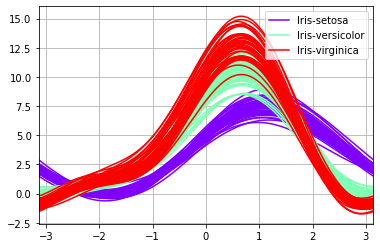

In [29]:
iris2 = iris.copy()
iris2 = iris2[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']]

plotter = pd.plotting.andrews_curves(iris2, 'Species', colormap = "rainbow") 
plotter.plot() 
plt.show()

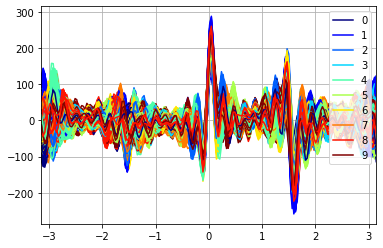

In [30]:
digit_pd = pd.DataFrame(digits_X)
digit_pd['label'] = digits_Y

plotter = pd.plotting.andrews_curves(digit_pd, 'label', colormap = 'jet') 
plotter.plot() 
plt.show()

Histograms of dependent variable

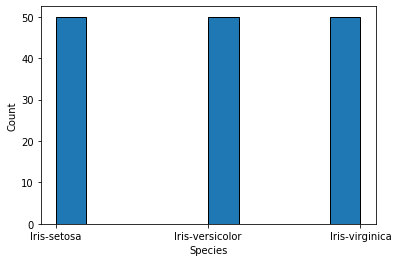

In [62]:
fig, ax = plt.subplots()

ax.set_xlabel("Species")
ax.set_ylabel("Count")
plt.hist(np.array(iris_Y), ec='black') 
plt.show()


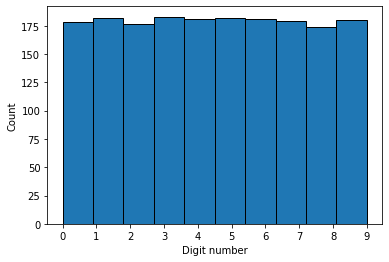

In [63]:
fig, ax = plt.subplots()

plt.hist(digits_Y, ec = 'black')  # arguments are passed to np.histogram
digit_vals = range(0,10)
ax.set_xlabel("Digit number")
ax.set_ylabel("Count")
plt.xticks(digit_vals)
plt.show()

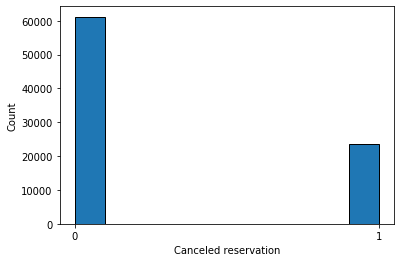

In [64]:
fig, ax = plt.subplots()

ax.set_xlabel("Canceled reservation")
cancel_vals = (0,1)
plt.xticks(cancel_vals)
ax.set_ylabel("Count")
plt.hist(np.array(hotel_Y_class), ec='black') 
plt.show()

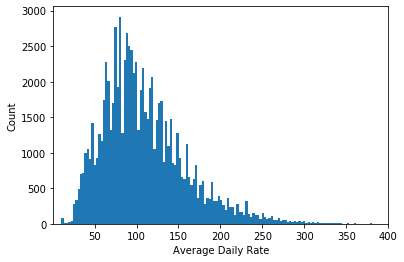

In [65]:
fig, ax = plt.subplots()

ax.set_xlabel("Average Daily Rate")
ax.set_ylabel("Count")
plt.hist(np.array(hotel_Y_reg), bins = "auto")
plt.xlim(xmin=1, xmax = 400)
plt.show()

# Baseline accuracy

Splitting the data in train and test sets

In [68]:
iris_train_X, iris_test_X, iris_train_Y, iris_test_Y = train_test_split(iris_X, iris_Y, random_state=2020, test_size=0.25)
digit_train_X, digit_test_X, digit_train_Y, digit_test_Y = train_test_split(digits_X, digits_Y, random_state=2020, test_size=0.25)
hotel_train_X_class, hotel_test_X_class, hotel_train_Y_class, hotel_test_Y_class = train_test_split(hotel_X_class, hotel_Y_class, random_state=2020, test_size=0.25)
hotel_train_X_reg, hotel_test_X_reg, hotel_train_Y_reg, hotel_test_Y_reg = train_test_split(hotel_X_reg, hotel_Y_reg, random_state=2020, test_size=0.25)

Zero rule for classification

In [69]:
def zero_rule(train_X, train_Y, test_X, test_Y):
    train_X = pd.DataFrame(train_X)
    train_Y = pd.DataFrame(train_Y)
    test_X = pd.DataFrame(test_X)
    test_Y = pd.DataFrame(test_Y)    
    train_merge = pd.merge(train_X, train_Y, left_index=True, right_index=True)
    test_merge = pd.merge(test_X, test_Y, left_index=True, right_index=True)
    output_values = np.array(train_merge.iloc[:,-1:])
    unique, counts = np.unique(output_values, return_counts=True)
    count_dict = dict(zip(unique, counts))
    prediction = max(count_dict, key=count_dict.get)
    prediction = np.repeat(prediction, test_merge.shape[0])
    prediction = prediction.reshape(test_merge.shape[0],1)
    cor_class = (np.sum(prediction == np.array(test_Y)))/test_Y.shape[0]
    #misc_class = (np.sum(prediction != np.array(test_Y)))/test_Y.shape[0]
    #return mis_class
    return cor_class

In [70]:
zero_rule(iris_train_X, iris_train_Y, iris_test_X, iris_test_Y)

0.2894736842105263

In [71]:
zero_rule(digit_train_X, digit_train_Y, digit_test_X, digit_test_Y)

0.09555555555555556

In [72]:
zero_rule(hotel_train_X_class, hotel_train_Y_class, hotel_test_X_class, hotel_test_Y_class)

0.7161549362305148

Median for regression

In [102]:
def reg_median(train_X, train_Y, test_X, test_Y):
    train_X = pd.DataFrame(train_X)
    train_Y = pd.DataFrame(train_Y)
    test_X = pd.DataFrame(test_X)
    test_Y = pd.DataFrame(test_Y)    
    train_merge = pd.merge(train_X, train_Y, left_index=True, right_index=True)
    test_merge = pd.merge(test_X, test_Y, left_index=True, right_index=True)
    output_values = np.array(train_merge.iloc[:,-1:])
    prediction = statistics.median(output_values)
    prediction = np.repeat(prediction, test_merge.shape[0])
    prediction = prediction.reshape(test_merge.shape[0],1)
    rmse = np.sqrt(np.mean((prediction - np.array(test_Y))**2))
    return rmse

In [103]:
reg_median(hotel_train_X_reg, hotel_train_Y_reg, hotel_test_X_reg, hotel_test_Y_reg)

51.01842561866706

# Iris PCA

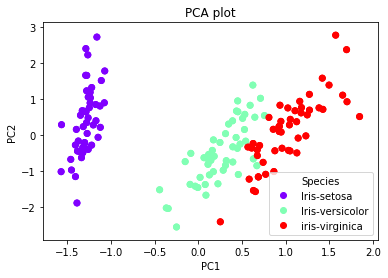

In [17]:
iris2 = iris.copy()

pca = PCA(n_components=2, whiten = True)
iris_pca = pca.fit(iris_X).transform(iris_X)

fig, ax = plt.subplots()

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.title("PCA plot")

iris2['Species'] = iris2['Species'].astype('category').cat.codes

scatter = ax.scatter(iris_pca[:,0], iris_pca[:,1], c = iris2['Species'], cmap = 'rainbow')

ax.scatter(iris_pca[:,0], iris_pca[:,1], c = iris2['Species'], cmap = 'rainbow')

species_labels = ('Iris-setosa', 'Iris-versicolor', 'iris-virginica')

plt.legend(handles=scatter.legend_elements()[0], title = "Species", labels=species_labels)

plt.show()

 Scree plot

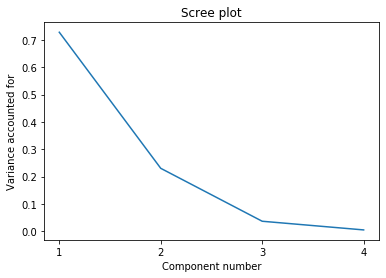

In [18]:
iris_scaled = StandardScaler().fit_transform(iris_X)
features = iris_scaled.T
cov_matrix = np.cov(features)

values, vectors = np.linalg.eig(cov_matrix)

explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))

fig, ax = plt.subplots()
comp = (1,2,3,4)
plt.plot(comp, explained_variances)
ax.set_xlabel("Component number")
ax.set_ylabel("Variance accounted for")
plt.title("Scree plot")
plt.xticks(comp)
plt.show()

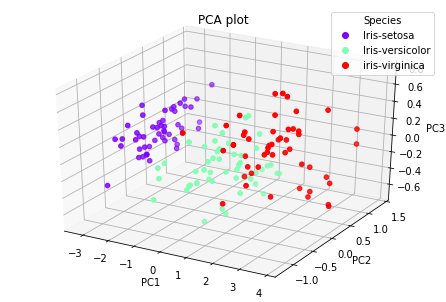

In [69]:
iris2 = iris.copy()
iris2['Species'] = iris2['Species'].astype('category').cat.codes

pca = PCA(n_components=3)
iris_pca = pca.fit(iris_X).transform(iris_X)

fig = pyplot.figure()
ax = Axes3D(fig)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA plot")

scatter = ax.scatter(iris_pca[:,0], iris_pca[:,1], iris_pca[:,2], c = iris2['Species'], cmap = 'rainbow')

ax.scatter(iris_pca[:,0], iris_pca[:,1], iris_pca[:,2], c = iris2['Species'], cmap = 'rainbow')

species_labels = ('Iris-setosa', 'Iris-versicolor', 'iris-virginica')

plt.legend(handles=scatter.legend_elements()[0], title = "Species", labels=species_labels)

plt.show()

Biplot

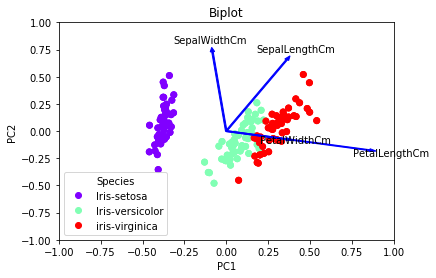

In [15]:
pca = PCA(n_components=2, whiten = True)
iris_pca = pca.fit(iris_X).transform(iris_X)
iris2 = iris.copy()
iris2['Species'] = iris2['Species'].astype('category').cat.codes

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = iris2['Species'], cmap = 'rainbow')
    scatter = plt.scatter(xs * scalex,ys * scaley, c = iris2['Species'], cmap = 'rainbow')
    varlist = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'blue', width = 0.009)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, varlist[i], color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.title("Biplot")
    species_labels = ('Iris-setosa', 'Iris-versicolor', 'iris-virginica')
    plt.legend(handles=scatter.legend_elements()[0], title = "Species", labels=species_labels)
    legend = plt.legend(handles=scatter.legend_elements()[0], title = "Species", labels=species_labels)
    frame = legend.get_frame()
    frame.set_facecolor('white')


myplot = myplot(iris_pca,np.transpose(pca.components_[0:2, :]))
plt.show()

# Iris LLE

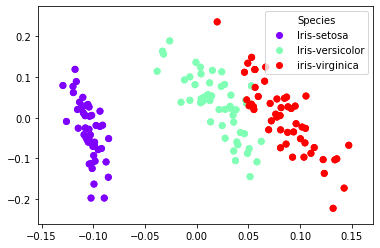

In [72]:
iris2 = iris.copy()

iris_X = iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
lle = LocallyLinearEmbedding(n_neighbors=80, n_components=2, method='standard', eigen_solver='dense', reg= 0.001)

lle_result = lle.fit_transform(iris_X)

fig, ax = plt.subplots()
iris2['Species'] = iris2['Species'].astype('category').cat.codes
scatter = ax.scatter(lle_result[:, 0], lle_result[:, 1], c = iris2['Species'], cmap = 'rainbow')
ax.scatter(lle_result[:, 0], lle_result[:, 1], c = iris2['Species'], cmap = 'rainbow')
species_labels = ('Iris-setosa', 'Iris-versicolor', 'iris-virginica')
plt.legend(handles=scatter.legend_elements()[0], title = "Species", labels=species_labels)

plt.show()

Reconstruction error

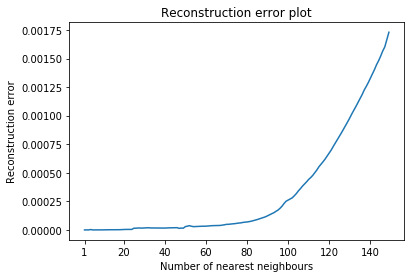

In [47]:
iris2 = iris.copy()
iris_X = iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]

errors = []
for k in range(1,150):
    lle = LocallyLinearEmbedding(n_neighbors=k, n_components=2, method='standard', eigen_solver='dense')
    lle_result = lle.fit_transform(iris_X)
    lle_error = lle.reconstruction_error_
    errors.append(lle_error)
    
k = range(1,150)
k_tick = (1,20,40,60,80,100,120,140)
plt.plot(k, errors)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error plot")
plt.xticks(k_tick)
plt.show()

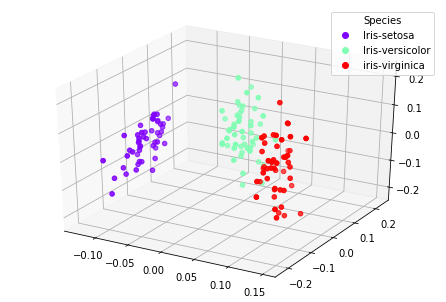

In [67]:
iris2 = iris.copy()

iris_X = iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
lle = LocallyLinearEmbedding(n_neighbors=100, n_components=3, method='standard', eigen_solver='dense', reg = 0.001)
lle_result = lle.fit_transform(iris_X)

fig = pyplot.figure()
ax = Axes3D(fig)
iris2['Species'] = iris2['Species'].astype('category').cat.codes
scatter = ax.scatter(lle_result[:, 0], lle_result[:, 1], lle_result[:, 2], c = iris2['Species'], cmap = 'rainbow')
ax.scatter(lle_result[:, 0], lle_result[:, 1], lle_result[:, 2], c = iris2['Species'], cmap = 'rainbow')
species_labels = ('Iris-setosa', 'Iris-versicolor', 'iris-virginica')
plt.legend(handles=scatter.legend_elements()[0], title = "Species", labels=species_labels)

plt.show()

# Iris t-SNE

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.896417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.509821
[t-SNE] KL divergence after 1000 iterations: 0.068362


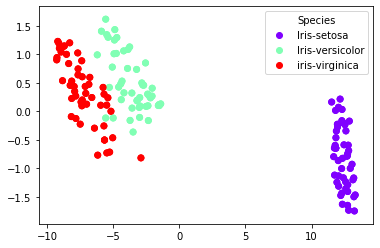

In [168]:
iris2 = iris.copy()
iris_X = iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
tsne = TSNE(n_components=2, n_iter=1000, verbose=1, init = 'random', early_exaggeration = 12, perplexity=50, method = 'exact', learning_rate=5, random_state = 2020)
tsne_result = tsne.fit_transform(iris_X)

fig, ax = plt.subplots()
iris2['Species'] = iris2['Species'].astype('category').cat.codes
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c = iris2['Species'], cmap = 'rainbow')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c = iris2['Species'], cmap = 'rainbow')
species_labels = ('Iris-setosa', 'Iris-versicolor', 'iris-virginica')
plt.legend(handles=scatter.legend_elements()[0], title = "Species", labels=species_labels)

plt.show()

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.896417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.531589
[t-SNE] KL divergence after 1000 iterations: 0.044377


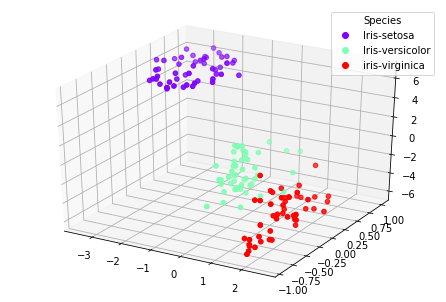

In [169]:
iris2 = iris.copy()
iris_X = iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]

tsne = TSNE(n_components=3, n_iter=1000, verbose=1, init = 'random', early_exaggeration = 12, perplexity=50, method = 'exact', learning_rate=5, random_state = 2020)
tsne_result = tsne.fit_transform(iris_X)

fig = pyplot.figure()
ax = Axes3D(fig)
iris2['Species'] = iris2['Species'].astype('category').cat.codes
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c = iris2['Species'], cmap = 'rainbow')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c = iris2['Species'], cmap = 'rainbow')
species_labels = ('Iris-setosa', 'Iris-versicolor', 'iris-virginica')
plt.legend(handles=scatter.legend_elements()[0], title = "Species", labels=species_labels)

plt.show()

# Digits PCA

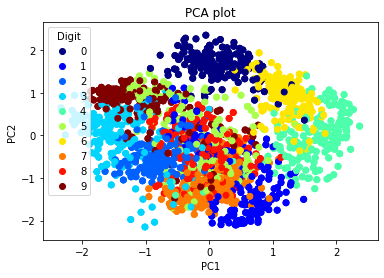

In [14]:
pca = PCA(n_components=2, whiten = True)
digit_pca = pca.fit(digits_X).transform(digits_X)

fig, ax = plt.subplots()
scatter = ax.scatter(digit_pca[:,0], digit_pca[:,1], c = digits_Y, cmap = 'jet')
ax.scatter(digit_pca[:,0], digit_pca[:,1], c = digits_Y, cmap = 'jet')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.title("PCA plot")

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

Scree plot

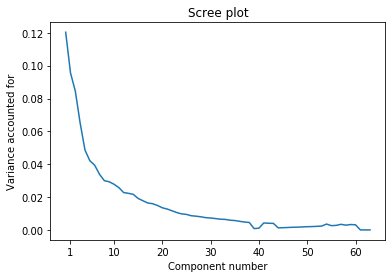

In [75]:
X_scaled = StandardScaler().fit_transform(digits_X)
features = X_scaled.T
cov_matrix = np.cov(features)

values, vectors = np.linalg.eig(cov_matrix)

explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))

fig, ax = plt.subplots()

ax.set_xlabel("Component number")
ax.set_ylabel("Variance accounted for")
plt.title("Scree plot")

comp_tick = (1,10,20,30,40,50,60)
comp = range(0, len(explained_variances))
plt.plot(comp, explained_variances)
ax.set_xlabel("Component number")
ax.set_ylabel("Variance accounted for")
plt.title("Scree plot")
plt.xticks(comp_tick)
plt.show()    

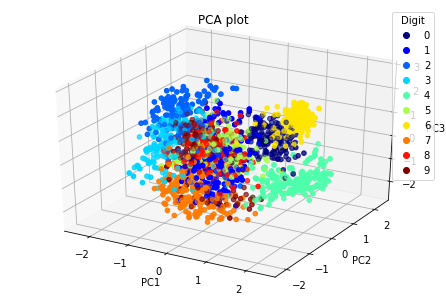

In [13]:
pca = PCA(n_components=3, whiten = True)
digit_pca = pca.fit(digits_X).transform(digits_X)

fig = pyplot.figure()
ax = Axes3D(fig)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA plot")

scatter = ax.scatter(digit_pca[:,0], digit_pca[:,1], digit_pca[:,2], c = digits_Y, cmap = 'jet')
ax.scatter(digit_pca[:,0], digit_pca[:,1], digit_pca[:,2], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

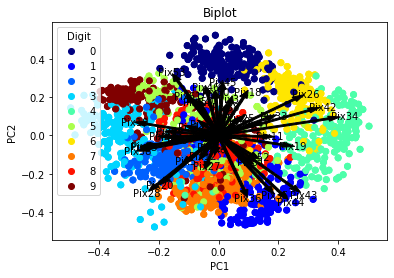

In [12]:
pca = PCA(n_components=2, whiten = True)
digit_pca = pca.fit(digits_X).transform(digits_X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = digits_Y, cmap = 'jet')
    scatter = plt.scatter(xs * scalex,ys * scaley, c = digits_Y, cmap = 'jet')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'black', width = 0.009)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Pix"+str(i), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.title("Biplot")
    digit_labels = range(10)
    plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)
    legend = plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)
    frame = legend.get_frame()
    frame.set_facecolor('white')


myplot = myplot(digit_pca,np.transpose(pca.components_[0:2, :]))
plt.show()

# Digits LLE

Standard LLE

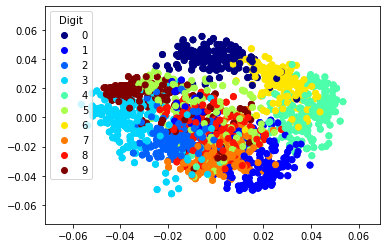

In [73]:
lle = LocallyLinearEmbedding(n_neighbors=1796, n_components=2, method='standard', eigen_solver='dense', reg = 0.001)
lle_results = lle.fit_transform(digits_X)

fig, ax = plt.subplots()
scatter = ax.scatter(lle_results[:, 0], lle_results[:, 1], c = digits_Y, cmap = 'jet')
ax.scatter(lle_results[:, 0], lle_results[:, 1], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

Standard LLE with $\lambda$ = 1

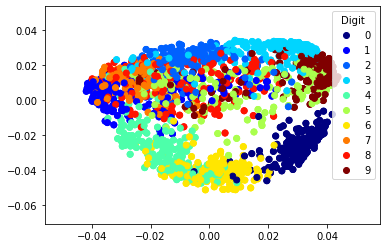

In [33]:
lle = LocallyLinearEmbedding(n_neighbors=350, n_components=2, method='standard', eigen_solver='dense', reg = 1)
lle_results = lle.fit_transform(digits_X)

fig, ax = plt.subplots()
scatter = ax.scatter(lle_results[:, 0], lle_results[:, 1], c = digits_Y, cmap = 'jet')
ax.scatter(lle_results[:, 0], lle_results[:, 1], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

Hessian LLE

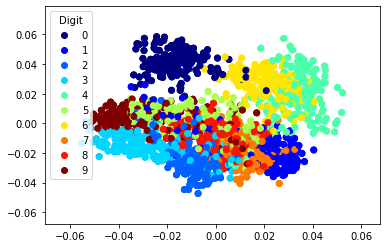

In [7]:
lle = LocallyLinearEmbedding(n_neighbors=800, n_components=2, method='hessian', eigen_solver='dense', reg = 0.001)
lle_results = lle.fit_transform(digits_X)

fig, ax = plt.subplots()
scatter = ax.scatter(lle_results[:, 0], lle_results[:, 1], c = digits_Y, cmap = 'jet')
ax.scatter(lle_results[:, 0], lle_results[:, 1], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

Modified LLE

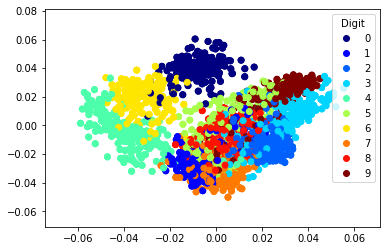

In [91]:
lle = LocallyLinearEmbedding(n_neighbors=800, n_components=2, method='modified', eigen_solver='dense', reg = 0.001)
lle_results = lle.fit_transform(digits_X)

fig, ax = plt.subplots()
scatter = ax.scatter(lle_results[:, 0], lle_results[:, 1], c = digits_Y, cmap = 'jet')
ax.scatter(lle_results[:, 0], lle_results[:, 1], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

Reconstruction error

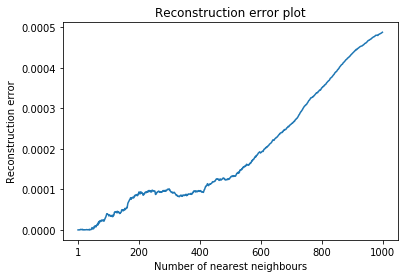

In [43]:
errors = []
for k in range(1,1000):
    lle = LocallyLinearEmbedding(n_neighbors=k, n_components=2, eigen_solver='dense')
    lle_results = lle.fit_transform(digits_X)
    lle_error = lle.reconstruction_error_
    errors.append(lle_error)
    
k = range(1,1000)
k_tick = (1,200,400,600,800,1000)
plt.plot(k, errors)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error plot")
plt.xticks(k_tick)
plt.show()

3D LLE

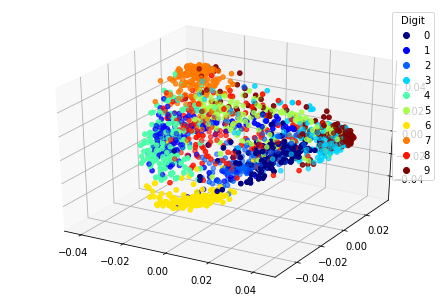

In [92]:
lle = LocallyLinearEmbedding(n_neighbors=350, n_components=3, method='standard', eigen_solver='dense', reg = 1)
lle_results = lle.fit_transform(digits_X)

fig = pyplot.figure()
ax = Axes3D(fig)

scatter = ax.scatter(lle_results[:, 0], lle_results[:, 1], lle_results[:, 2], c = digits_Y, cmap = 'jet')
ax.scatter(lle_results[:, 0], lle_results[:, 1], lle_results[:, 2], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

# Digits t-SNE

Exact approach

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 6.745421
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.768746
[t-SNE] KL divergence after 1000 iterations: 0.890753


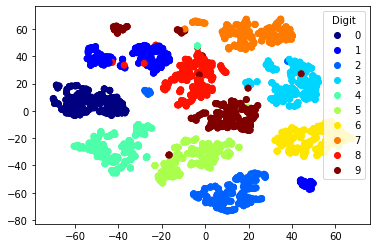

In [217]:
tsne = TSNE(n_components=2, n_iter=1000, verbose=1, perplexity=10, init = 'random', early_exaggeration = 12, method = 'exact', learning_rate=20, random_state = 2020)
tsne_results = tsne.fit_transform(digits_X)

fig, ax = plt.subplots()
scatter = ax.scatter(tsne_results[:, 0],tsne_results[:, 1], c = digits_Y, cmap = 'jet')
ax.scatter(tsne_results[:, 0],tsne_results[:, 1], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

Barnes-hut

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.004s...
[t-SNE] Computed neighbors for 1797 samples in 0.277s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 6.847674
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.460770
[t-SNE] KL divergence after 1000 iterations: 0.938903


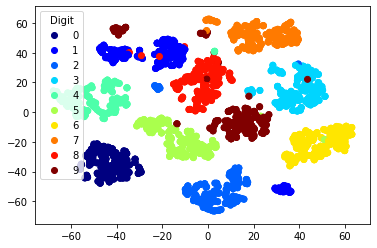

In [220]:
tsne = TSNE(n_components=2, n_iter=1000, verbose=1, perplexity=10, init = 'random', early_exaggeration = 12, method = 'barnes_hut', learning_rate=20, random_state = 2020)
tsne_results = tsne.fit_transform(digits_X)

fig, ax = plt.subplots()
scatter = ax.scatter(tsne_results[:, 0],tsne_results[:, 1], c = digits_Y, cmap = 'jet')
ax.scatter(tsne_results[:, 0],tsne_results[:, 1], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

3D exact t-SNE

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 6.745421
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.017134
[t-SNE] KL divergence after 1000 iterations: 0.730251


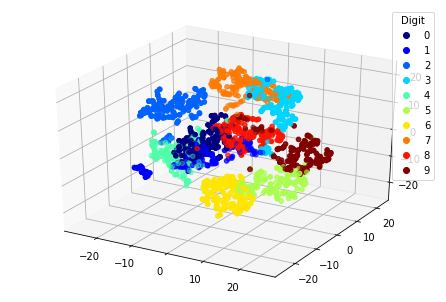

In [221]:
tsne = TSNE(n_components=3, n_iter=1000, verbose=1, perplexity=10, init = 'random', early_exaggeration = 12, method = 'exact', learning_rate=20, random_state = 2020)
tsne_results = tsne.fit_transform(digits_X)

fig = pyplot.figure()
ax = Axes3D(fig)
scatter = ax.scatter(tsne_results[:, 0],tsne_results[:, 1], tsne_results[:, 2], c = digits_Y, cmap = 'jet')
ax.scatter(tsne_results[:, 0],tsne_results[:, 1], tsne_results[:, 2], c = digits_Y, cmap = 'jet')

digit_labels = range(10)
plt.legend(handles=scatter.legend_elements()[0], title = "Digit", labels=digit_labels)

plt.show()

# Classification and regression

This section is done per dataset, where each data set is loaded in to ensure it is "clean".

# Iris

In [225]:
df = pd.read_csv('iris.csv')
df['Species'] = df['Species'].astype('category')
X = df.drop(['Species', 'Id'], axis=1)
y = df['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2020)

# Random Forest

basic model

In [226]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
print('train accuracy',rfc.score(X_train,y_train),'test accuracy',rfc.score(X_test,y_test))

train accuracy 1.0 test accuracy 0.868421052631579


grid search

In [200]:
start = time.time()
rfc_model = RandomForestClassifier(n_jobs=-1,random_state=2020)
clf = GridSearchCV(rfc_model,
                   {'criterion': ['gini', 'entropy'], 'n_estimators': [100,200], 'min_samples_split' : [2,3,5,10], 
                    'max_features': [None,'sqrt']},cv=5,n_jobs=1)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

0.9910714285714286
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
25.171701431274414


train model

In [227]:
start = time.time()

n_trees = [1,2,5,10,20,50,100,200,500]
train_acc_rf = np.zeros(len(n_trees))
test_acc_rf = np.zeros(len(n_trees))


for index,i in enumerate(n_trees):
    rfc = RandomForestClassifier(criterion = 'gini' ,n_estimators=i , random_state=2020, n_jobs=-1, oob_score = False, 
                                 min_samples_split=10, max_features = 'sqrt')
    rfc.fit(X_train, y_train)
    train_acc_rf[index] =  rfc.score(X_train,y_train)
    test_acc_rf[index] =  rfc.score(X_test,y_test)
    print('#no of trees',i,'train accuracy',train_acc_rf[index],'test accuracy',test_acc_rf[index])


print('Time=',time.time()-start)

#no of trees 1 train accuracy 0.9464285714285714 test accuracy 0.868421052631579
#no of trees 2 train accuracy 0.9910714285714286 test accuracy 0.868421052631579
#no of trees 5 train accuracy 0.9910714285714286 test accuracy 0.8947368421052632
#no of trees 10 train accuracy 0.9910714285714286 test accuracy 0.8947368421052632
#no of trees 20 train accuracy 0.9910714285714286 test accuracy 0.8947368421052632
#no of trees 50 train accuracy 0.9910714285714286 test accuracy 0.8947368421052632
#no of trees 100 train accuracy 0.9910714285714286 test accuracy 0.8947368421052632
#no of trees 200 train accuracy 0.9821428571428571 test accuracy 0.8947368421052632
#no of trees 500 train accuracy 0.9821428571428571 test accuracy 0.8947368421052632
Time= 4.072137355804443


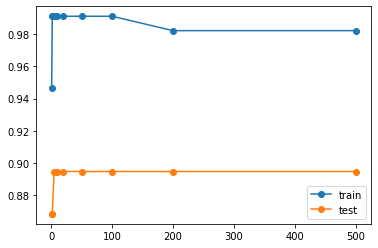

In [228]:
plt.plot(n_trees,train_acc_rf,'-o',label = 'train')
plt.plot(n_trees,test_acc_rf,'-o',label = 'test')
plt.legend()
plt.show()

In [229]:
feature_imp = pd.Series(rfc.feature_importances_,index=X.columns)#.sort_values(ascending=False)
feature_imp.sort_values(ascending = False)[0:5]

PetalWidthCm     0.485589
PetalLengthCm    0.412650
SepalLengthCm    0.073444
SepalWidthCm     0.028316
dtype: float64

# XGBoost

basic model

In [230]:
xgb_class = xgb.XGBClassifier(n_jobs=-1)
xgb_class.fit(X_train, y_train)
print('train accuracy',xgb_class.score(X_train,y_train),'test accuracy',xgb_class.score(X_test,y_test))

train accuracy 1.0 test accuracy 0.8947368421052632


grid search

In [203]:
start = time.time()
xgb_model = xgb.XGBClassifier(n_jobs=-1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,5,8,10], 'eta': [0.05,0.1,0.2,0.3], 'reg_lambda' : [0,1], 'alpha' : [0,1], 'subsample' : [0.8,1],
                    'colsample_bytree': [0.7,1], 'n_estimators' : [200,500]}, verbose=1, n_jobs=-1,cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\viola\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1264 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2164 tasks      | elapsed:   29.1s


0.9818181818181818
{'alpha': 0, 'colsample_bytree': 0.7, 'eta': 0.05, 'max_depth': 2, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 0.8}
33.017635345458984


[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:   32.8s finished


train model

In [236]:
start = time.time()
n_trees = [2,5,10,20,50,100,200,500,1000]
train_acc_xgb = np.zeros(len(n_trees))
test_acc_xgb = np.zeros(len(n_trees))

for index,i in enumerate(n_trees):
    xgb_class = xgb.XGBClassifier(n_jobs=-1, eta = 0.05, max_depth = 2, n_estimators = i, alpha = 0, reg_lambda = 1,
                                  gamma = 0,min_child_weight =1, colsample_bytree  = 0.7, subsample = 0.8)
    xgb_class.fit(X_train, y_train)
    train_acc_xgb[index] =  xgb_class.score(X_train,y_train)
    test_acc_xgb[index] =  xgb_class.score(X_test,y_test)
    print('#no of trees',i,'train accuracy',train_acc_xgb[index],'test accuracy',test_acc_xgb[index])


print('Time=',time.time()-start)

#no of trees 2 train accuracy 0.9642857142857143 test accuracy 0.8157894736842105
#no of trees 5 train accuracy 0.9642857142857143 test accuracy 0.8421052631578947
#no of trees 10 train accuracy 0.9910714285714286 test accuracy 0.868421052631579
#no of trees 20 train accuracy 0.9910714285714286 test accuracy 0.8947368421052632
#no of trees 50 train accuracy 0.9910714285714286 test accuracy 0.8947368421052632
#no of trees 100 train accuracy 1.0 test accuracy 0.8947368421052632
#no of trees 200 train accuracy 1.0 test accuracy 0.868421052631579
#no of trees 500 train accuracy 1.0 test accuracy 0.868421052631579
#no of trees 1000 train accuracy 1.0 test accuracy 0.868421052631579
Time= 1.1618897914886475


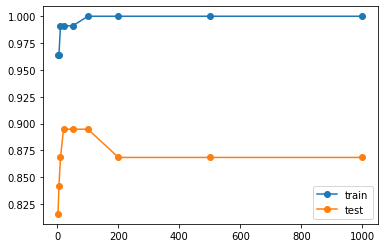

In [237]:
plt.plot(n_trees,train_acc_xgb,'-o',label = 'train')
plt.plot(n_trees,test_acc_xgb,'-o',label = 'test')
plt.legend()
plt.show()

In [238]:
feature_imp2 = pd.Series(xgb_class.feature_importances_,index=X.columns)#.sort_values(ascending=False)
feature_imp2.sort_values(ascending = False)[0:5]

PetalWidthCm     0.564728
PetalLengthCm    0.303336
SepalWidthCm     0.080333
SepalLengthCm    0.051603
dtype: float32

### Models comparison

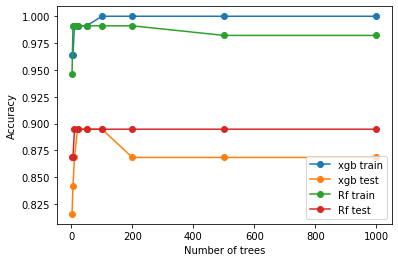

In [239]:
plt.plot(n_trees,train_acc_xgb,'-o',label = 'xgb train')
plt.plot(n_trees,test_acc_xgb,'-o',label = 'xgb test')
plt.plot(n_trees,train_acc_rf,'-o',label = 'Rf train')
plt.plot(n_trees,test_acc_rf,'-o',label = 'Rf test')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('iris')
plt.show()

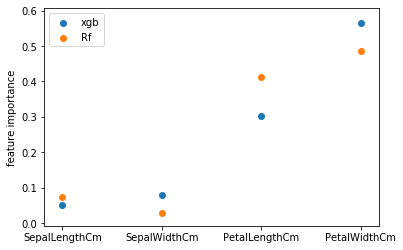

In [240]:
plt.scatter(feature_imp2.index,feature_imp2, label = 'xgb')
plt.scatter(feature_imp.index,feature_imp, label = 'Rf')
plt.legend()
plt.ylabel('feature importance')
#plt.savefig('iris imp')
plt.show()

In [241]:
print(confusion_matrix(y_test, xgb_class.predict(X_test)))
print(confusion_matrix(y_test, rfc.predict(X_test)))
res_rf = [i for i, val in enumerate(y_test== rfc.predict(X_test)) if not val]
res_xgb = [i for i, val in enumerate(y_test== xgb_class.predict(X_test)) if not val]
res_xgb = set(res_xgb)
res_rf = set(res_rf)

print('rf',len(res_rf))
print('xgb',len(res_xgb))
print('repeatable mistakes',len(res_xgb & res_rf))
print('unique mistakes',len(res_xgb | res_rf))

[[15  0  0]
 [ 0  9  2]
 [ 0  3  9]]
[[15  0  0]
 [ 0  9  2]
 [ 0  2 10]]
rf 4
xgb 5
repeatable mistakes 4
unique mistakes 5


# Digits

In [242]:
digits = datasets.load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.25)

# Random Forest

basic model

In [243]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
print('train accuracy',rfc.score(X_train,y_train),'test accuracy',rfc.score(X_test,y_test))

train accuracy 1.0 test accuracy 0.9733333333333334


search grid

In [25]:
start = time.time()
rfc_model = RandomForestClassifier(n_jobs=1,random_state=2020)
clf = GridSearchCV(rfc_model,
                   {'criterion': ['gini', 'entropy'], 'n_estimators': [100,200], 'min_samples_split' : [2,3,5,10], 
                    'max_features': [ None,'sqrt']},cv=5 ,n_jobs=12)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

0.9747790169351507
{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
31.467809915542603


train model

In [244]:
start = time.time()
n_trees = [2,5,10,20,50,100,200,500]
train_acc_rf = np.zeros(len(n_trees))
test_acc_rf = np.zeros(len(n_trees))

for index,i in enumerate(n_trees):
    print(index)
    rfc = RandomForestClassifier(criterion = 'entropy' ,n_estimators=i , random_state=2020, n_jobs=-1, oob_score = False, 
                                 min_samples_split=2, max_features = 'sqrt')
    rfc.fit(X_train, y_train)
    train_acc_rf[index] =  rfc.score(X_train,y_train)
    test_acc_rf[index] =  rfc.score(X_test,y_test)
    print('#no of trees',i,'train accuracy',train_acc_rf[index],'test accuracy',test_acc_rf[index])


print('Time=',time.time()-start)

0
#no of trees 2 train accuracy 0.9131403118040089 test accuracy 0.7866666666666666
1
#no of trees 5 train accuracy 0.9910913140311804 test accuracy 0.9111111111111111
2
#no of trees 10 train accuracy 1.0 test accuracy 0.9533333333333334
3
#no of trees 20 train accuracy 1.0 test accuracy 0.9644444444444444
4
#no of trees 50 train accuracy 1.0 test accuracy 0.98
5
#no of trees 100 train accuracy 1.0 test accuracy 0.9755555555555555
6
#no of trees 200 train accuracy 1.0 test accuracy 0.98
7
#no of trees 500 train accuracy 1.0 test accuracy 0.9733333333333334
Time= 4.637590408325195


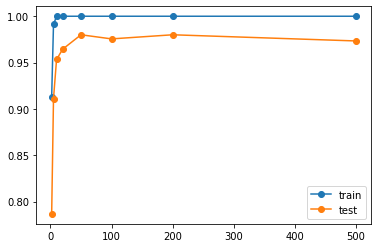

In [245]:
plt.plot(n_trees,train_acc_rf,'-o',label = 'train')
plt.plot(n_trees,test_acc_rf,'-o',label = 'test')
plt.legend()
plt.show()

In [246]:
feature_imp = pd.Series(rfc.feature_importances_)#.sort_values(ascending=False)
feature_imp.sort_values(ascending = False)[0:5]

21    0.055304
43    0.054875
42    0.049448
26    0.044460
33    0.038731
dtype: float64

# XGBoost

basic model

In [247]:
xgb_class = xgb.XGBClassifier(n_jobs=-1)
xgb_class.fit(X_train, y_train)
print('train accuracy',xgb_class.score(X_train,y_train),'test accuracy',xgb_class.score(X_test,y_test))

train accuracy 1.0 test accuracy 0.9622222222222222


search grid

In [30]:
start = time.time()
xgb_model = xgb.XGBClassifier(n_jobs=-1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,5,8,10], 'eta': [0.1], 'reg_lambda' : [0,1], 'alpha' : [0,1], 'subsample' : [0.8,1],
                    'colsample_bytree': [0.7,1], 'n_estimators' : [200]}, verbose=1, n_jobs=-1,cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.0min finished


0.9666171003717473
{'alpha': 0, 'colsample_bytree': 1, 'eta': 0.1, 'max_depth': 2, 'n_estimators': 200, 'reg_lambda': 0, 'subsample': 0.8}
178.85646152496338


In [248]:
start = time.time()
xgb_model = xgb.XGBClassifier(n_jobs=-1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2], 'eta': [0.05,0.1,0.2,0.3], 'reg_lambda' : [0], 'reg_alpha' : [0], 'subsample' : [0.8],
                    'colsample_bytree' : [1], 'n_estimators' : [200,500]}, verbose=1, n_jobs=-1,cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 

train model

In [249]:
start = time.time()
n_trees = [2,5,10,20,50,100,200,500]
train_acc_xgb = np.zeros(len(n_trees))
test_acc_xgb = np.zeros(len(n_trees))

for index,i in enumerate(n_trees):
    xgb_class = xgb.XGBClassifier(n_jobs=-1, eta = 0.3, max_depth = 2, n_estimators = i, alpha = 0, reg_lambda = 0,
                                  gamma = 0,min_child_weight =1, colsample_bytree  = 1, subsample = 0.8)
    xgb_class.fit(X_train, y_train)
    train_acc_xgb[index] =  xgb_class.score(X_train,y_train)
    test_acc_xgb[index] =  xgb_class.score(X_test,y_test)
    print('#no of trees',i,'train accuracy',train_acc_xgb[index],'test accuracy',test_acc_xgb[index])


print('Time=',time.time()-start)

#no of trees 2 train accuracy 0.8426132145508537 test accuracy 0.8422222222222222
#no of trees 5 train accuracy 0.896807720861173 test accuracy 0.9066666666666666
#no of trees 10 train accuracy 0.9435783221974758 test accuracy 0.92
#no of trees 20 train accuracy 0.9821826280623608 test accuracy 0.9444444444444444
#no of trees 50 train accuracy 1.0 test accuracy 0.9644444444444444
#no of trees 100 train accuracy 1.0 test accuracy 0.9711111111111111
#no of trees 200 train accuracy 1.0 test accuracy 0.9733333333333334
#no of trees 500 train accuracy 1.0 test accuracy 0.9711111111111111
Time= 6.06374716758728


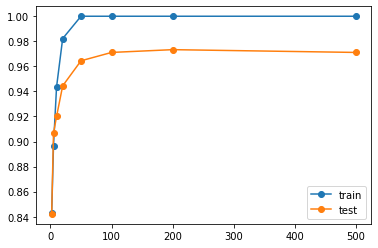

In [250]:
plt.plot(n_trees,train_acc_xgb,'-o',label = 'train')
plt.plot(n_trees,test_acc_xgb,'-o',label = 'test')
plt.legend()
plt.show()

In [251]:
feature_imp2 = pd.Series(xgb_class.feature_importances_)#.sort_values(ascending=False)
feature_imp2.sort_values(ascending = False)[0:5]

33    0.086944
62    0.063220
23    0.048929
36    0.048836
21    0.046425
dtype: float32

### Models comparison

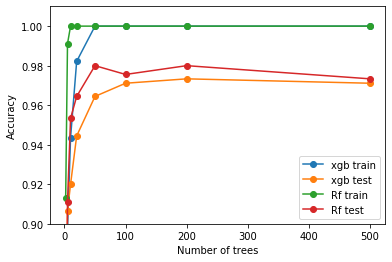

In [252]:
plt.plot(n_trees,train_acc_xgb,'-o',label = 'xgb train')
plt.plot(n_trees,test_acc_xgb,'-o',label = 'xgb test')
plt.plot(n_trees,train_acc_rf,'-o',label = 'Rf train')
plt.plot(n_trees,test_acc_rf,'-o',label = 'Rf test')
plt.ylim(0.9, 1.01)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('digits')
plt.show()

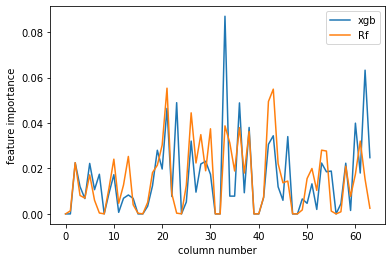

In [253]:
plt.plot(feature_imp2, label = 'xgb')
plt.plot(feature_imp, label = 'Rf')
plt.legend()
plt.xlabel('column number')
plt.ylabel('feature importance')
#plt.savefig('digits imp')
plt.show()

In [254]:
print(confusion_matrix(y_test, xgb_class.predict(X_test)))
print(confusion_matrix(y_test, rfc.predict(X_test)))
res_rf = [i for i, val in enumerate(y_test== rfc.predict(X_test)) if not val]
res_xgb = [i for i, val in enumerate(y_test== xgb_class.predict(X_test)) if not val]
res_xgb = set(res_xgb)
res_rf = set(res_rf)

print('rf',len(res_rf))
print('xgb',len(res_xgb))
print('repeatable mistakes',len(res_xgb & res_rf))
print('unique mistakes',len(res_xgb | res_rf))

[[40  0  0  0  1  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0]
 [ 0  0  0 48  0  1  0  0  1  1]
 [ 1  0  0  0 46  0  0  0  0  1]
 [ 0  0  0  0  0 40  0  0  1  2]
 [ 0  0  0  0  0  0 47  0  0  0]
 [ 0  0  0  0  0  0  0 44  0  1]
 [ 0  0  0  0  0  1  0  0 38  0]
 [ 1  1  0  0  0  0  0  0  0 41]]
[[40  0  0  0  1  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0]
 [ 0  0  0 49  0  1  0  0  1  0]
 [ 0  0  0  0 47  0  0  1  0  0]
 [ 0  0  0  0  0 41  0  0  0  2]
 [ 1  0  0  0  0  0 46  0  0  0]
 [ 0  0  0  0  1  0  0 44  0  0]
 [ 0  2  0  0  1  0  0  0 36  0]
 [ 0  0  0  0  0  1  0  0  0 42]]
rf 12
xgb 13
repeatable mistakes 7
unique mistakes 18


# Hotel bookings

In [294]:
df = pd.read_csv('hotel_bookings.csv')

df = df.drop(labels ='company',axis = 1)
df = df.drop(labels ='agent',axis = 1)
df = df.drop(labels = 'reservation_status_date',axis = 1)
df = df.drop(labels ='reservation_status',axis = 1) # with this column accuracy goes to ~100%
#df = df.drop(labels = 'country',axis = 1)
df = df.dropna()
df = df[df['adr']>10]
names = df.select_dtypes(include=object).columns
for col in names:
    df[col] = df[col].astype('category')
df.drop_duplicates(inplace=True)

encoding = 'ordinal'
if encoding =='nominal':
    df = pd.get_dummies(df)
    df_new = df
else:
    df_new = df
    enc = OrdinalEncoder()
    enc.fit(df_new[names])
    df_new[names] = enc.transform(df_new[names])

# Classification

In [256]:
X = df_new.loc[:, df_new.columns != 'is_canceled']
y = df_new['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.25)

# Random forest

basic model

In [257]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
print('train accuracy',rfc.score(X_train,y_train),'test accuracy',rfc.score(X_test,y_test))

train accuracy 0.9976696216284306 test accuracy 0.8430325932923949


grid search

In [ ]:
start = time.time()
rfc_model = RandomForestClassifier(n_jobs=-1,random_state=2020)
clf = GridSearchCV(rfc_model,
                   {'criterion': ['gini', 'entropy'], 'n_estimators': [100,200], 'min_samples_split' : [2,3,5], 
                    'max_features': [None,'sqrt']},cv=5,n_jobs=1)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

train model

In [258]:
start = time.time()

n_trees = [1,2,5,10,20,50,100,200,500,1000]
train_acc_rf = np.zeros(len(n_trees))
test_acc_rf = np.zeros(len(n_trees))


for index,i in enumerate(n_trees):
    rfc = RandomForestClassifier(criterion = 'gini' ,n_estimators=i , random_state=2020, n_jobs=-1, oob_score = False, 
                                 min_samples_split=3, max_features = 'sqrt')
    rfc.fit(X_train, y_train)
    train_acc_rf[index] =  rfc.score(X_train,y_train)
    test_acc_rf[index] =  rfc.score(X_test,y_test)
    print('#no of trees',i,'train accuracy',train_acc_rf[index],'test accuracy',test_acc_rf[index])


print('Time=',time.time()-start)

#no of trees 1 train accuracy 0.8942512084901353 test accuracy 0.7663675011809163
#no of trees 2 train accuracy 0.9169723976129367 test accuracy 0.7901747756258857
#no of trees 5 train accuracy 0.9631548284495111 test accuracy 0.8130373169579593
#no of trees 10 train accuracy 0.9803334960399314 test accuracy 0.8282947567312234
#no of trees 20 train accuracy 0.989308601930435 test accuracy 0.8376476145488899
#no of trees 50 train accuracy 0.994252783070116 test accuracy 0.8412848370335381
#no of trees 100 train accuracy 0.9956069218535956 test accuracy 0.8433160132262636
#no of trees 200 train accuracy 0.99617377064668 test accuracy 0.8446386395843174
#no of trees 500 train accuracy 0.9966303988411092 test accuracy 0.8448748228625413
#no of trees 1000 train accuracy 0.9966776362405328 test accuracy 0.8443079829948039
Time= 42.46142840385437


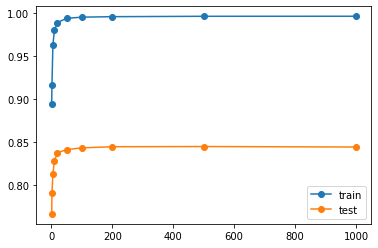

In [259]:
plt.plot(n_trees,train_acc_rf,'-o',label = 'train')
plt.plot(n_trees,test_acc_rf,'-o',label = 'test')
plt.legend()
plt.show()

In [260]:
feature_imp = pd.Series(rfc.feature_importances_,index=X.columns)#.sort_values(ascending=False)
feature_imp.sort_values(ascending = False)[0:5]

lead_time                    0.152192
country                      0.107047
adr                          0.104816
arrival_date_day_of_month    0.073799
arrival_date_week_number     0.069507
dtype: float64

# XGBoost

basic model

In [261]:
xgb_class = xgb.XGBClassifier(n_jobs=-1)
xgb_class.fit(X_train, y_train)
print('train accuracy',xgb_class.score(X_train,y_train),'test accuracy',xgb_class.score(X_test,y_test))

train accuracy 0.8722700719583051 test accuracy 0.8425602267359471


grid search

In [ ]:
start = time.time()
xgb_model = xgb.XGBClassifier(n_jobs=-1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,5,8], 'eta': [0.1], 'reg_lambda' : [0,1], 'alpha' : [0,1], 'subsample' : [0.8,1],
                    'colsample_bytree': [0.7,1], 'n_estimators' : [200]}, verbose=1, n_jobs=-1,cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

In [ ]:
start = time.time()
xgb_model = xgb.XGBClassifier(n_jobs=-1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [8], 'eta': [0.05,0.1,0.2,0.3], 'reg_lambda' : [1], 'reg_alpha' : [1], 'subsample' : [0.8]
                    , 'colsample_bytree': [1], 'n_estimators' : [200,500]}, verbose=1, n_jobs=-1,cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

train model

In [262]:
start = time.time()
n_trees = [1,2,5,10,20,50,100,200,500,1000]
train_acc_xgb = np.zeros(len(n_trees))
test_acc_xgb = np.zeros(len(n_trees))

for index,i in enumerate(n_trees):
    xgb_class = xgb.XGBClassifier(n_jobs=-1, eta = 0.05, max_depth = 8, n_estimators = i, alpha = 0, reg_lambda = 1,
                                  gamma = 0,min_child_weight =1, colsample_bytree  = 0.8, subsample = 1)
    xgb_class.fit(X_train, y_train)
    train_acc_xgb[index] =  xgb_class.score(X_train,y_train)
    test_acc_xgb[index] =  xgb_class.score(X_test,y_test)
    print('#no of trees',i,'train accuracy',train_acc_xgb[index],'test accuracy',test_acc_xgb[index])


print('Time=',time.time()-start)

#no of trees 1 train accuracy 0.7951156528995891 test accuracy 0.7917335852621634
#no of trees 2 train accuracy 0.807728038545718 test accuracy 0.8041095890410959
#no of trees 5 train accuracy 0.814734919460234 test accuracy 0.8132735002361833
#no of trees 10 train accuracy 0.8186083862129777 test accuracy 0.8181861124232405
#no of trees 20 train accuracy 0.8203404241918468 test accuracy 0.8196032120925838
#no of trees 50 train accuracy 0.8304334818687116 test accuracy 0.828389230042513
#no of trees 100 train accuracy 0.8420696279267506 test accuracy 0.8355692017005196
#no of trees 200 train accuracy 0.8578784109338834 test accuracy 0.8438828530940009
#no of trees 500 train accuracy 0.8952431938780331 test accuracy 0.8500708549834671
#no of trees 1000 train accuracy 0.9315215166354375 test accuracy 0.8510155880963628
Time= 68.402996301651


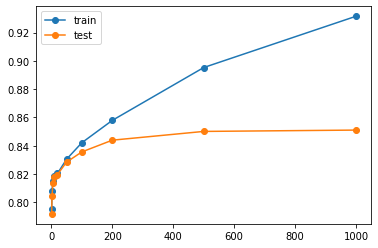

In [263]:
plt.plot(n_trees,train_acc_xgb,'-o',label = 'train')
plt.plot(n_trees,test_acc_xgb,'-o',label = 'test')
plt.legend()
plt.show()

In [264]:
feature_imp2 = pd.Series(xgb_class.feature_importances_,index=X.columns)#.sort_values(ascending=False)
feature_imp2.sort_values(ascending = False)[0:5]

required_car_parking_spaces    0.411049
deposit_type                   0.162877
market_segment                 0.053216
previous_cancellations         0.049350
total_of_special_requests      0.037719
dtype: float32

### Models comparison

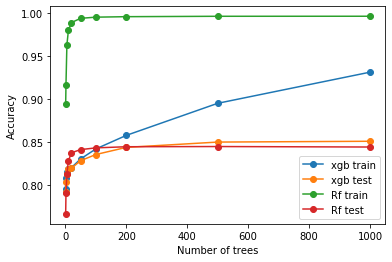

In [292]:
plt.plot(n_trees,train_acc_xgb,'-o',label = 'xgb train')
plt.plot(n_trees,test_acc_xgb,'-o',label = 'xgb test')
plt.plot(n_trees,train_acc_rf,'-o',label = 'Rf train')
plt.plot(n_trees,test_acc_rf,'-o',label = 'Rf test')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('hotel class')
plt.show()

In [266]:
print(confusion_matrix(y_test, xgb_class.predict(X_test)))
print(confusion_matrix(y_test, rfc.predict(X_test)))
res_rf = [i for i, val in enumerate(y_test== rfc.predict(X_test)) if not val]
res_xgb = [i for i, val in enumerate(y_test== xgb_class.predict(X_test)) if not val]
res_xgb = set(res_xgb)
res_rf = set(res_rf)

print('rf',len(res_rf))
print('xgb',len(res_xgb))
print('repeatable mistakes',len(res_xgb & res_rf))
print('unique mistakes',len(res_xgb | res_rf))

[[13963  1198]
 [ 1956  4053]]
[[14089  1072]
 [ 2224  3785]]
rf 3296
xgb 3154
repeatable mistakes 2531
unique mistakes 3919


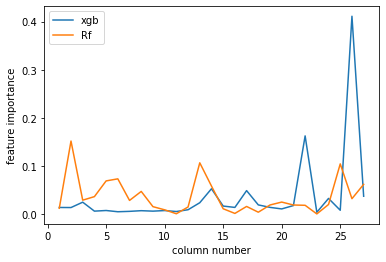

In [268]:
plt.plot(range(1,28),feature_imp2, label = 'xgb')
plt.plot(range(1,28),feature_imp, label = 'Rf')
plt.xlabel('column number')
plt.ylabel('feature importance')
#plt.savefig('hotel class imp')

plt.legend()
plt.show()

# Regression


In [295]:
X = df_new.loc[:, df_new.columns != 'adr']
y = df_new['adr']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020)


# Random forest

basic model

In [270]:
rfr = RandomForestRegressor(n_jobs=-1)
rfr.fit(X_train, y_train)
y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
print('train accuracy',np.sqrt(np.mean((y_train-y_pred_train)**2)),'test accuracy',np.sqrt(np.mean((y_test-y_pred_test)**2)))

train accuracy 9.246645322605513 test accuracy 16.98526166046948


grid search

In [ ]:
start = time.time()
rfr_model = RandomForestRegressor(n_jobs=1,random_state=2020)
clf = GridSearchCV(rfr_model,
                   {'criterion': ['mse'], 'n_estimators': [100,200], 'min_samples_split' : [2,3,5,8], 
                    'max_features': [ None ,round(len(df. columns) /3) ,'sqrt']},cv=5,n_jobs=12)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

For regression with criterion 'mae' it optimizes with L1-norm and it takes much more time than 'mse' which optimizes for L2-norm so i didnt use it, 'mae' approximatly takes O(N^2)

In [296]:
start = time.time()
n_trees = [1,2,5,10,20,50,100,200,500,1000,2000,3000]
train_rmse_rf = np.zeros(len(n_trees))
test_rmse_rf = np.zeros(len(n_trees))

mf = round(len(df. columns) /3)

for index,i in enumerate(n_trees):
    rfr = RandomForestRegressor(n_estimators=i , random_state=2020, n_jobs=-1 ,oob_score = False, criterion= 'mse',
                                max_features = mf, min_samples_split = 2)
    rfr.fit(X_train, y_train)
    
    y_pred_train = rfr.predict(X_train)
    y_pred_test = rfr.predict(X_test)
    
    train_rmse_rf[index] = np.sqrt(np.mean((y_train-y_pred_train)**2))
    test_rmse_rf[index] = np.sqrt(np.mean((y_test-y_pred_test)**2))
    
    print('#no of trees',i,'train rmse',train_rmse_rf[index],'test rmse',test_rmse_rf[index])

print('Time=',time.time()-start)

#no of trees 1 train rmse 16.918644597428003 test rmse 27.692516966943717
#no of trees 2 train rmse 12.821733914301385 test rmse 22.956243240149355
#no of trees 5 train rmse 10.18431923433948 test rmse 19.140325572443913
#no of trees 10 train rmse 9.13981171059956 test rmse 18.032685325880628
#no of trees 20 train rmse 8.051438637662358 test rmse 17.76486100146634
#no of trees 50 train rmse 9.898086194596488 test rmse 16.8287062785545
#no of trees 100 train rmse 9.859728018801896 test rmse 16.58528454954658
#no of trees 200 train rmse 10.163332153705449 test rmse 16.453259099515687
#no of trees 500 train rmse 10.154766702584551 test rmse 16.367702027026546
#no of trees 1000 train rmse 9.954359046399826 test rmse 16.306125898023275
#no of trees 2000 train rmse 9.888069107677248 test rmse 16.291405240653035
#no of trees 3000 train rmse 9.927670380171975 test rmse 16.283504330019717
Time= 262.302686214447


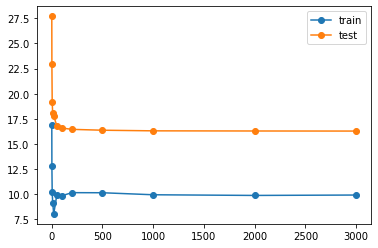

In [298]:
plt.plot(n_trees,train_rmse_rf,'-o',label = 'train')
plt.plot(n_trees,test_rmse_rf,'-o',label = 'test')
plt.legend()
plt.show()

In [299]:
feature_imp = pd.Series(rfr.feature_importances_,index=X.columns)
feature_imp.sort_values(ascending=False)[0:5]

arrival_date_week_number    0.192311
reserved_room_type          0.115190
arrival_date_month          0.081514
lead_time                   0.080894
hotel                       0.079456
dtype: float64

# XGBoost

basic model

In [274]:
xgb_reg = xgb.XGBRegressor(n_jobs=-1)
xgb_reg.fit(X_train, y_train)

y_pred_train = xgb_reg.predict(X_train)
y_pred_test = xgb_reg.predict(X_test)
print('train accuracy',np.sqrt(np.mean((y_train-y_pred_train)**2)),'test accuracy',np.sqrt(np.mean((y_test-y_pred_test)**2)))

train accuracy 15.711095545866023 test accuracy 19.122544622700797


grid search

In [ ]:
start = time.time()
xgb_reg = xgb.XGBRegressor(n_jobs=12)
clf = GridSearchCV(xgb_reg,
                   {'max_depth': [2,5,8], 'eta': [0.1], 'reg_lambda' : [0,1], 'alpha' : [0,1], 'subsample' : [0.8,1],
                    'colsample_bytree': [0.7,1], 'n_estimators' : [200]}, verbose=1, n_jobs=-1,cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

In [59]:
start = time.time()
xgb_model = xgb.XGBRegressor(n_jobs=-1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [8], 'eta': [0.05,0.1,0.2,0.3], 'reg_lambda' : [1], 'reg_alpha' : [0], 'subsample' : [1],
                    'colsample_bytree' : [0.7], 'n_estimators' : [200,500]}, verbose=1, n_jobs=-1,cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
print(time.time()-start)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.2min finished


0.7846304087782645
{'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}
204.39415097236633


train model

In [297]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020)
n_trees = [1,2,5,10,20,50,100,200,500,1000,2000,3000]
train_rmse_xgb = np.zeros(len(n_trees))
test_rmse_xgb = np.zeros(len(n_trees))


for index,i in enumerate(n_trees):
    xgb_reg = xgb.XGBRegressor(n_jobs=-1, eta = 0.05, max_depth = 8, n_estimators = i, subsample = 1,
                               alpha = 1, reg_lambda = 0, gamma = 0, min_child_weight =1,  colsample_bytree  = 0.7)
    xgb_reg.fit(X_train, y_train)
    
    y_pred_train = xgb_reg.predict(X_train)
    y_pred_test = xgb_reg.predict(X_test)
    train_rmse_xgb[index] = np.sqrt(np.mean((y_train-y_pred_train)**2))
    test_rmse_xgb[index] = np.sqrt(np.mean((y_test-y_pred_test)**2))
    
    
    print('#no of trees',i,'train rmse',train_rmse_xgb[index],'test rmse',test_rmse_xgb[index])


print('Time=',time.time()-start)

#no of trees 1 train rmse 115.87997486105989 test rmse 114.15325806711826
#no of trees 2 train rmse 110.61736421742032 test rmse 108.77953210437914
#no of trees 5 train rmse 96.3167521599596 test rmse 94.39723303416095
#no of trees 10 train rmse 77.27440563448484 test rmse 75.1089896606478
#no of trees 20 train rmse 51.45546567232029 test rmse 49.48468604755344
#no of trees 50 train rmse 23.112047757662086 test rmse 22.665646048595548
#no of trees 100 train rmse 16.753667578657115 test rmse 18.258057120856236
#no of trees 200 train rmse 14.178947112826002 test rmse 17.016566580467032
#no of trees 500 train rmse 11.932732273059285 test rmse 16.338440064945825
#no of trees 1000 train rmse 9.924809749129457 test rmse 16.011697519651452
#no of trees 2000 train rmse 7.383133610392911 test rmse 15.82608850210202
#no of trees 3000 train rmse 5.852678286224247 test rmse 15.800770467749079
Time= 184.44254636764526


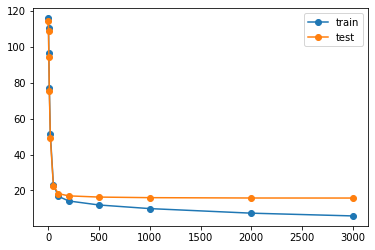

In [305]:
plt.plot(n_trees,train_rmse_xgb,'-o',label = 'train')
plt.plot(n_trees,test_rmse_xgb,'-o',label = 'test')
plt.legend()
plt.show()

In [306]:
feature_imp2 = pd.Series(xgb_reg.feature_importances_,index=X.columns)#.sort_values(ascending=False)
feature_imp2.sort_values(ascending = False)[0:5]

reserved_room_type    0.128447
children              0.108120
hotel                 0.100303
deposit_type          0.079040
meal                  0.067885
dtype: float32

### Models comparison

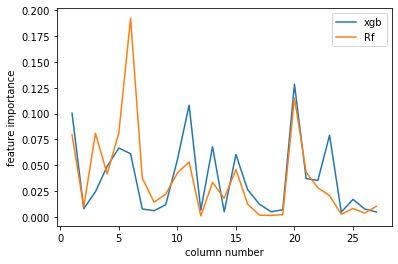

In [307]:
plt.plot(range(1,28),feature_imp2, label = 'xgb')
plt.plot(range(1,28),feature_imp, label = 'Rf')
plt.legend()
plt.xlabel('column number')
plt.ylabel('feature importance')
#plt.savefig('hotel reg')
plt.show()

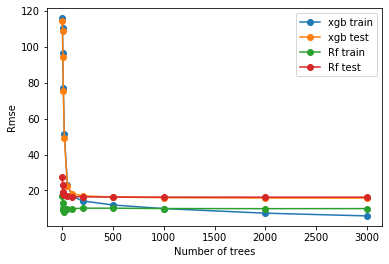

In [303]:
plt.plot(n_trees,train_rmse_xgb,'-o',label = 'xgb train')
plt.plot(n_trees,test_rmse_xgb,'-o',label = 'xgb test')
plt.plot(n_trees,train_rmse_rf,'-o',label = 'Rf train')
plt.plot(n_trees,test_rmse_rf,'-o',label = 'Rf test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Rmse')
#plt.savefig('hotel reg imp')
plt.show()

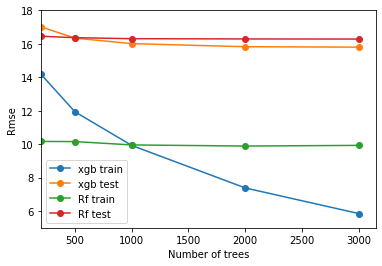

In [308]:
plt.plot(n_trees,train_rmse_xgb,'-o',label = 'xgb train')
plt.plot(n_trees,test_rmse_xgb,'-o',label = 'xgb test')
plt.plot(n_trees,train_rmse_rf,'-o',label = 'Rf train')
plt.plot(n_trees,test_rmse_rf,'-o',label = 'Rf test')
plt.legend()
plt.xlim(200,)
plt.ylim(5,18)
plt.xlabel('Number of trees')
plt.ylabel('Rmse')
#plt.savefig('hotel reg imp2')
plt.show()